In [1]:
from pprint import pprint as pp

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

mpl.rcParams['figure.dpi'] = 500

In [2]:
energies = [-4109.00941469,
            -4100.97162191,
            -4092.63197519,
            -4084.03190795,
            -4075.33034836,
            -4065.91677493,
            -4056.48595094,
            -4047.89409332,
            -4038.56283037,
            -4029.43964490]

In [3]:
E_vs_VO = {index: energy for index, energy in enumerate(energies)}
pp(E_vs_VO)

{0: -4109.00941469,
 1: -4100.97162191,
 2: -4092.63197519,
 3: -4084.03190795,
 4: -4075.33034836,
 5: -4065.91677493,
 6: -4056.48595094,
 7: -4047.89409332,
 8: -4038.56283037,
 9: -4029.4396449}


In [4]:
E_recon = -4445.01964141
E_bulk = -23.087792205
E_O = -5.025


def surfen(e_slab, n_ti, n_vo, mu_o, area_coeff):
    s_e = e_slab - n_ti * E_bulk + n_vo * (E_O + mu_o)
    s_e /= area_coeff
    return np.round(s_e, 4)

In [13]:
mu_o_arr = np.linspace(-5, -2.5, 500)
surfens = {}
for n_vo, e_slab in E_vs_VO.items():
    surfens[n_vo] = []
    for mu_o in mu_o_arr:
        surfens[n_vo].append(surfen(e_slab, 180, n_vo, mu_o, 18))

sto_surfen = surfens[0][0]

surfens['recon'] = []
for mu_o in mu_o_arr:
    surfens['recon'].append(surfen(E_recon, 198, 9, mu_o, 18))

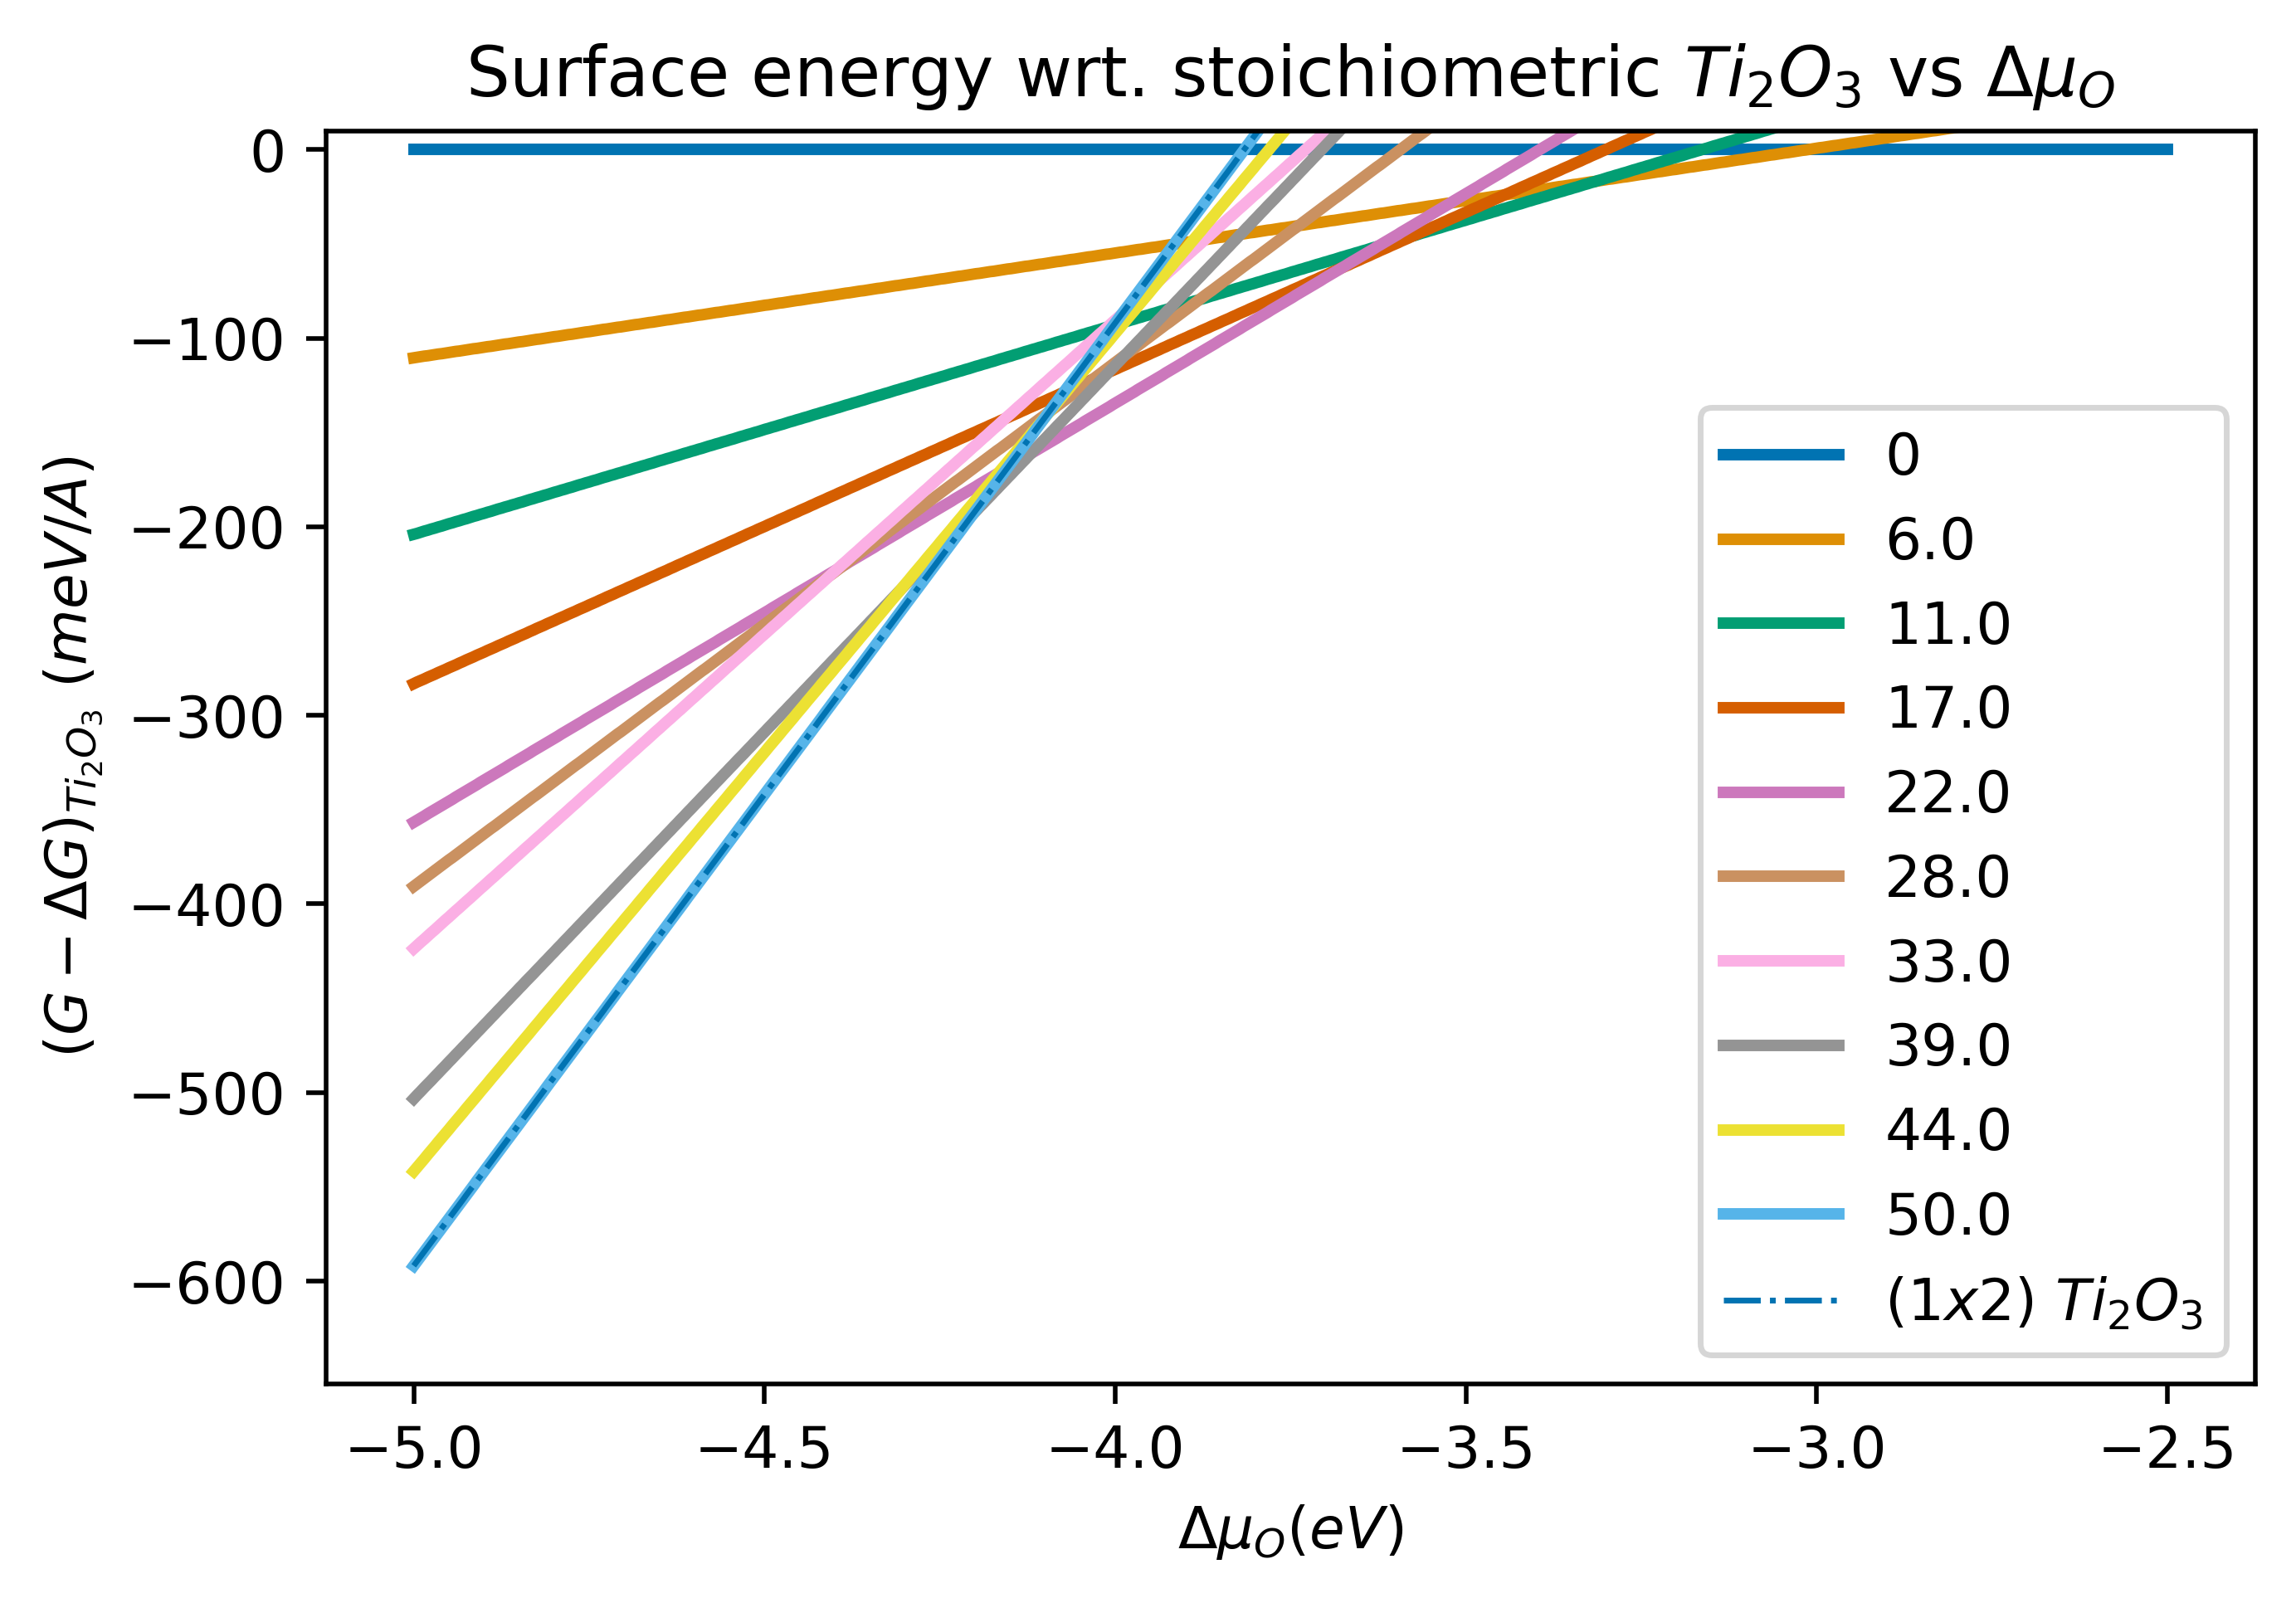

In [15]:
fig, ax = plt.subplots()
colors = iter(sns.color_palette("colorblind", 11).as_hex())
fig.figsize = (12, 12)
for n_vo, data in surfens.items():
    data = np.asarray(data)
    data -= sto_surfen
    data = data * 1000
    if n_vo == 'recon':
        label, lw, ls = '$(1x2)$ $Ti_2O_3$', 1, '-.'
    else:
        label, lw, ls = n_vo if n_vo == 0 else np.round(100 * n_vo / 18), 2, '-'

    ax.plot(mu_o_arr, data, label=f"{label}", linewidth=lw, linestyle=ls, c=next(colors))
ax.set_ylim(top=10.0)
ax.set_ylabel("$(G-\\Delta G)_{Ti_2O_3}$ $(meV/A)$")
ax.set_xlabel("$\\Delta\\mu_O(eV)$")
ax.set_title("Surface energy wrt. stoichiometric $Ti_2O_3$ vs $\\Delta\\mu_O$")
ax.legend()